# Normalizing flows

In [1]:
%cd ..

/data/mas322/amex-project


In [2]:
import yaml
import os
import importlib
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from src.experiments.static_preprocessing_methods.min_max_scaling import MinMaxTimeSeries
from src.lib import experimentation
import src.experiments.static_preprocessing_methods.experiment_setup as spm

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : True,
    'drop_last' : True,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}
# load corrupted data
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=MinMaxTimeSeries(),
    corrupt_func=spm.undo_min_max_corrupt_func,
    **data_loader_kwargs)

for X, y in train_loader:
    break
X, y = X.numpy()[:, :, 11:], y.numpy()[11:]
print(f"X shape: {X.shape}")

X shape: (1024, 13, 177)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist 
import pyro.distributions.transforms as T

## Simple normalizing flow example

`T.ExpTransform()` implements $g(x)=\exp(x)$, for which $\log\left(\left| \frac{dg}{dx}\right|\right)=x$. We can pass in a list of transformations to the below method, and a base distribution e.g. `dist.Normal` object. The transformations are applied from left to right when going forwards

In [11]:
?dist.TransformedDistribution

Init signature:
dist.TransformedDistribution(
    base_distribution,
    transforms,
    validate_args=None,
)
Docstring:     
Wraps :class:`torch.distributions.transformed_distribution.TransformedDistribution` with
:class:`~pyro.distributions.torch_distribution.TorchDistributionMixin`.
File:           ~/anaconda3/envs/cudf-torch/lib/python3.10/site-packages/pyro/distributions/torch.py
Type:           DistributionMeta
Subclasses:     AffineBeta, FoldedDistribution, InverseGamma, LKJ

`T.AffineTransform` does a linear shift and scale

Learnable transformations should inherit from `dist.torch_transform.TransformModule`, not the `T` verison, which is only for fixed parameters. However, this is just child of both `T.Transform` and `nn.modules.module.Module`.

In [4]:
# example
def get_iaf_bijector(num_layers, scale_and_shift_dims, input_dim, dev):
    transforms = []
    for _ in range(num_layers):
        scale_and_shift = pyro.nn.AutoRegressiveNN(input_dim, scale_and_shift_dims, param_dims=[1, 1])
        transforms.append(T.AffineAutoregressive(scale_and_shift, stable=True))
        transforms.append(T.Permute(torch.randperm(input_dim, dtype=torch.long, device=dev)))
    # skip the last permutation
    return T.ComposeTransformModule(transforms[:-1])

DEV = torch.device('cuda', 5)

base_dist = dist.Normal(torch.zeros(177, device=DEV), torch.ones(177, device=DEV))
bijector = get_iaf_bijector(2, [256], 177, DEV).to(DEV)

In [10]:
# forward
out = bijector(torch.tensor(X).to(DEV).flatten(0, 1))
out

tensor([[ 0.0094,  0.0780,  0.3357,  ...,  0.2932,  0.4504,  0.0438],
        [ 0.0097,  0.0813,  0.3347,  ...,  0.2970,  0.3759,  0.0158],
        [ 0.0104,  0.0537,  0.3351,  ...,  0.2942,  0.3783,  0.0219],
        ...,
        [ 0.0122,  0.0324,  0.3348,  ...,  0.2886,  0.4976,  0.1553],
        [ 0.0126,  0.0341,  0.3349,  ...,  0.2869,  0.4957, -0.0017],
        [ 0.0088,  0.0230,  0.2102,  ...,  0.1631, -0.0016,  0.0251]],
       device='cuda:5', grad_fn=<AddBackward0>)

In [11]:
# inverse call
bijector.inv(out)

tensor([[0.7235, 0.0055, 0.6719,  ..., 0.5000, 0.4285, 0.0189],
        [0.7173, 0.1038, 0.6868,  ..., 0.5000, 0.4278, 0.0189],
        [0.7252, 0.1366, 0.6860,  ..., 0.5000, 0.4275, 0.0189],
        ...,
        [0.6754, 0.0111, 0.4775,  ..., 0.5000, 0.4308, 0.0185],
        [0.6858, 0.0112, 0.4785,  ..., 0.5000, 0.4298, 0.0185],
        [0.5828, 0.0062, 0.3779,  ..., 0.5000, 0.0053, 0.0185]],
       device='cuda:5')

In [5]:
flow_dist = dist.TransformedDistribution(base_dist, [bijector])

epochs = 1
optim = torch.optim.Adam(bijector.parameters(), lr=1e-3)
for epoch_idx in tqdm(range(epochs), desc = "Epoch: "):
    for X, _ in (pbar := tqdm(train_loader)):
        X = X.flatten(0, 1)[:, 11:].to(DEV)
        optim.zero_grad()
        loss = -flow_dist.log_prob(X).mean()
        loss.backward()
        optim.step()
        pbar.set_description(f"Loss : {loss.detach().cpu().item():.4f}")
        flow_dist.clear_cache()
        del X, loss

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

ValueError: Expected value argument (Tensor of shape (13312, 177)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([177]), scale: torch.Size([177])), but found invalid values:
tensor([[-1.1671e-01,  1.1777e-01, -2.6893e-01,  ...,  1.3653e-01,
          1.0293e-01,  1.4628e+00],
        [-1.0690e-01,  1.1310e-01, -2.2581e-01,  ...,  1.3152e-01,
          1.0276e-01,  1.2569e+00],
        [-1.2455e-01,  1.1984e-01, -3.0641e-01,  ...,  1.4204e-01,
          1.1465e-01,  1.6196e+00],
        ...,
        [ 2.8297e-01, -4.7330e-01, -5.2042e-01,  ..., -6.5786e-01,
         -5.1815e-01, -4.1372e-01],
        [ 3.4143e-01, -4.3128e-01,  2.1879e-01,  ..., -6.0557e-01,
         -1.2954e+00, -3.4450e-01],
        [-6.8723e-01,  1.1125e-03,  3.5299e-01,  ...,  5.3059e-01,
         -2.3010e+00,  3.7948e-01]], device='cuda:5', grad_fn=<StackBackward0>)

In [7]:
for X, y in train_loader:
    break
X, y = X.numpy()[:, :, 11:], y.numpy()[11:]

In [13]:
torch.save(bijector.state_dict(), os.path.join(cfg['checkpoint_directory'], "bijector-model-11-07-2023"))

In [5]:
bijector.load_state_dict(torch.load(os.path.join(cfg['checkpoint_directory'], "bijector-model-11-07-2023")))

<All keys matched successfully>

Somehow just one lazy initialisation of the bijector uses up 18 GB of GPU memory, so trick is to save model state after training, then apply transformation using CPU perhaps?

In [11]:
out = bijector.inv(torch.tensor(X).flatten(0, 1).to(DEV))

In [20]:
out = out.detach().cpu().numpy()
X = X.reshape((-1, 177))

The below plots are misleading due to the random permutations...

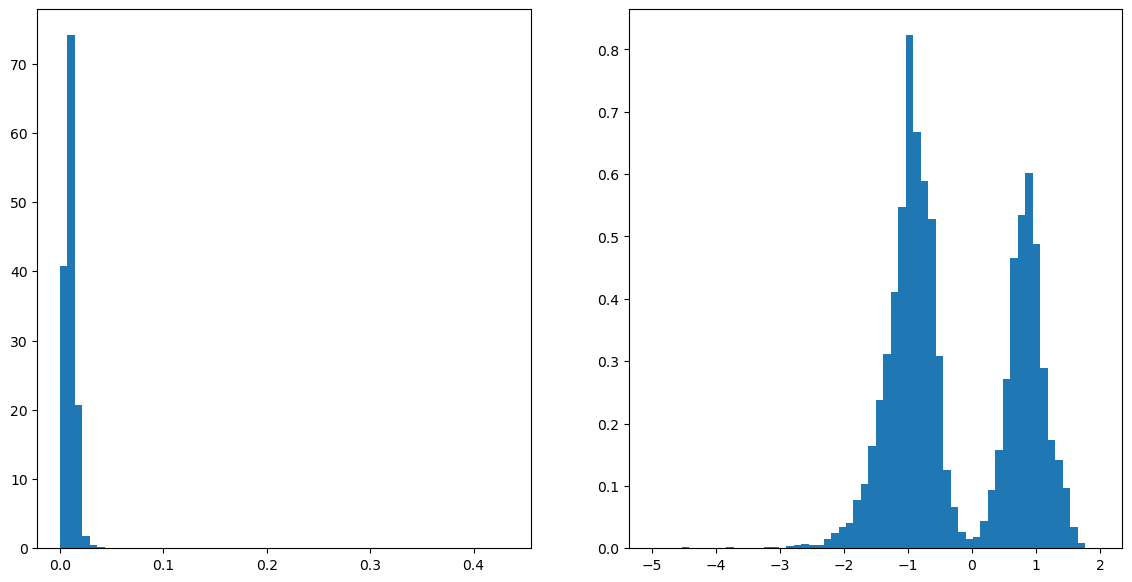

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:, 13], bins=60, density=True)
axs[1].hist(out[:, 13], bins=60, density=True)
plt.show()

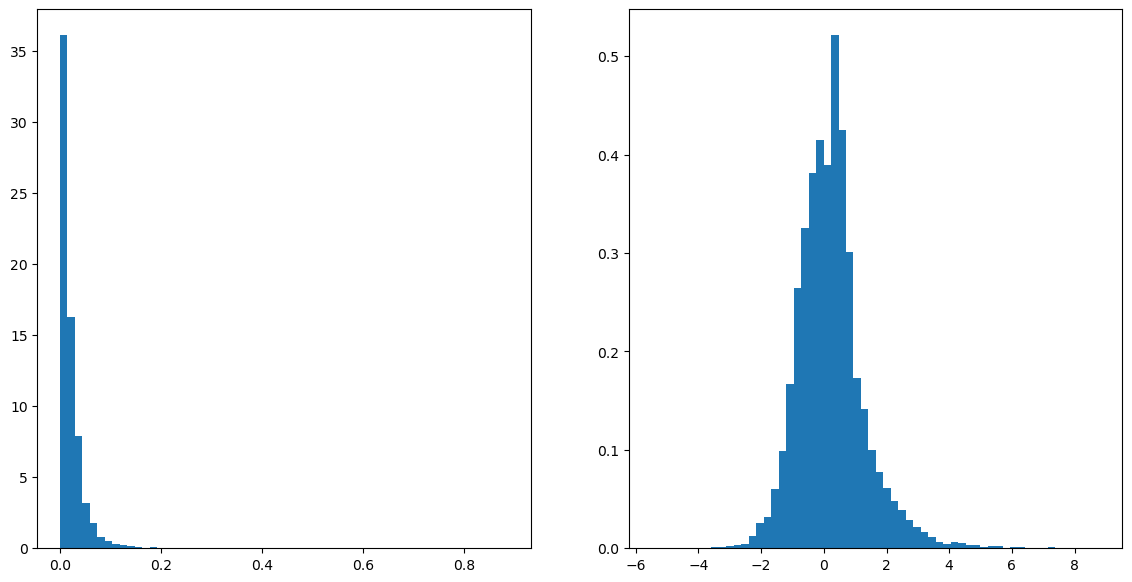

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   25], bins=60, density=True)
axs[1].hist(out[:, 25], bins=60, density=True)
plt.show()

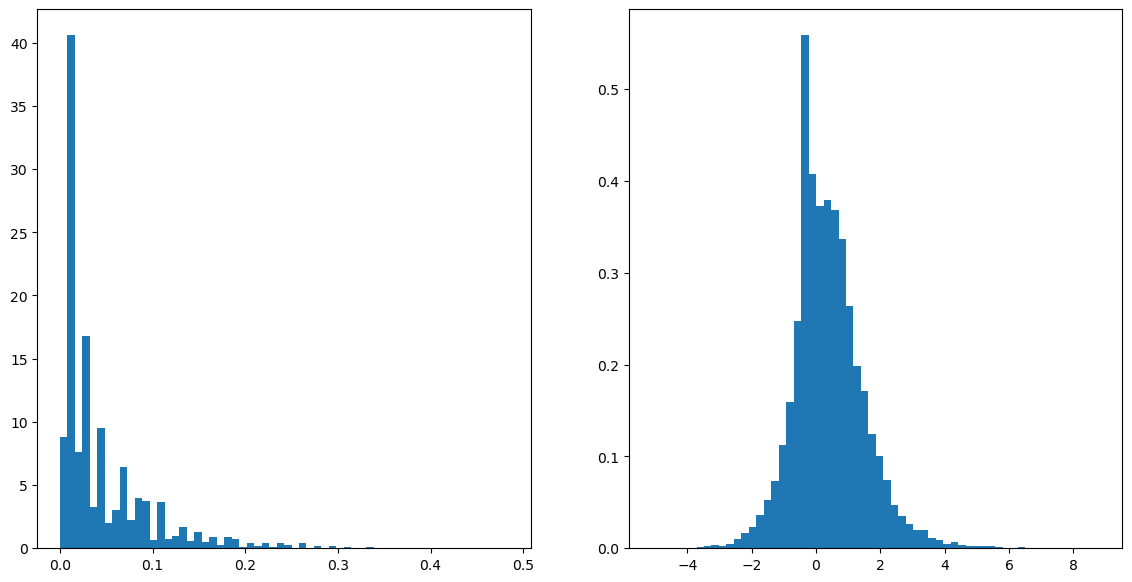

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   70], bins=60, density=True)
axs[1].hist(out[:, 70], bins=60, density=True)
plt.show()

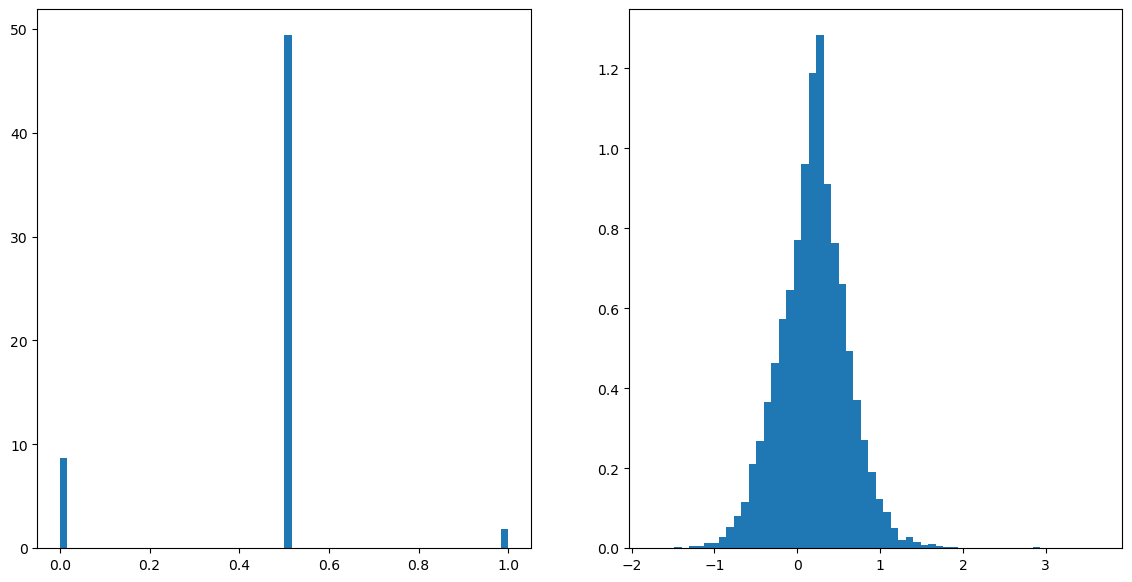

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
axs[0].hist(X[:,   100], bins=60, density=True)
axs[1].hist(out[:, 100], bins=60, density=True)
plt.show()

In [44]:
f"{torch.cuda.mem_get_info(5)[0] / 1024 ** 2} MB"

'6188.0625 MB'

In [55]:
X_processed = []
y_processed = []

for X, y in tqdm(val_loader):
    with torch.no_grad():
        X_in = torch.tensor(X[:, :, 11:]).flatten(0, 1).to(DEV)
        X_out = bijector.inv(X_in)
        X_out = X_out.unflatten(0, (X.shape[0], X.shape[1])).detach().cpu().numpy()
    X = np.concatenate((X[:, :, :11], X_out), 2)
    X_processed.append(X)
    y_processed.append(y)    

  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_3551810/468380385.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_in = torch.tensor(X[:, :, 11:]).flatten(0, 1).to(DEV)


In [56]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-X_val.npy"), np.concatenate(X_processed, axis=0))

In [57]:
np.save(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-y_val.npy"), np.concatenate(y_processed, axis=0))

In [62]:
temp = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-X_train.npy"))

## Training model on RealNVP-transformed data

Step 1: Load the data

In [4]:
X_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-X_train.npy"))
y_train = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-y_train.npy"))
X_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-X_val.npy"))
y_val = np.load(os.path.join(cfg['dataset_directory'], 'transformed', f"RealNVP-1-y_val.npy"))

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : False,
    'drop_last' : False,
}

train_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).type(torch.float32),
        torch.from_numpy(y_train).type(torch.float32)
    ), **data_loader_kwargs)

val_loader = torch.utils.data.DataLoader(
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val).type(torch.float32),
        torch.from_numpy(y_val).type(torch.float32)
    ), **data_loader_kwargs)

In [5]:
from src.models.basic_grunet import GRUNetBasic

loss_fn = F.binary_cross_entropy
model = GRUNetBasic(188, 128, 2, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
early_stopper = experimentation.EarlyStopper(patience=5)

In [9]:
hist = experimentation.fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler, num_epochs=50, early_stopper=early_stopper, device_ids='cpu', verbose=True)

Using device = cpu


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: all elements of input should be between 0 and 1

In [14]:
for i, (X, y) in enumerate(train_loader):
    if not torch.all(torch.isfinite(X)):
        print(len(X[~torch.isfinite(X)]))
        print(i)

4
2
21
7
7
18
168
20
30
23
7
46
835
48
39
50
30
61
7
62
53
74
93
84
14
85
19
90
4
95
48
97
7
101
30
104
24
108
97
109
59
110
1
112
38
115
59
117
19
124
16
134
48
136
19
137
26
141
23
144
24
151
39
157
19
158
45
170
25
171
32
175
45
182
45
184
1
186
469
191
8
194
89
195
21
202
304
203
63
205
1
207
10
209
125
210
2
239
13
242
53
245
31
247
39
248
47
251
58
265
8
277
21
279
31
281
11
285
399
294
15
295
37
311
38
317
17
324
19
329
15
334
53
338
46
340
49
348
110
354
